In [153]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation, NMF

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.nmf import Nmf

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
# from pyLDAvis import gensim_models as pg
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)


In [154]:
cwd = os.getcwd()
data = cwd + "/amazon_r.csv"

df = pd.read_csv(data)
print(df.shape)
df.head()

(1597, 27)


id       asins   brand                  categories  \
0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

  colors             dateAdded           dateUpdated  \
0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
2  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
3  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
4  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   

  reviews.rating  \
0            5.0   
1            5.0   
2            4.0   
3            5.0   
4            5.0   

                                                                                                                                                              reviews.sourceURLs  \
0  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
1  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
2  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
3  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   
4  https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7   

                                                                                                                                                                                                                                                                                                  reviews.text  \
0  I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage.Fortunately, I had friends who owned each, so I ended up buying the paperwhite on this basis: both m...   
1  Allow me to preface this with a little history. I am (was) a casual reader who owned a Nook Simple Touch from 2011. I've read the Harry Potter series, Girl with the Dragon Tattoo series, 1984, Brave New World, and a few other key titles. Fair to say my Nook did not get as much use as many others...   
2                                                                                                                       I am enjoying it so far. Great for reading. Had the original Fire since 2012. The Fire used to make my eyes hurt if I read too long. Haven't experienced that with the Paperwhite yet.   
3  I bought one of the first Paperwhites and have been very pleased with it its been a constant companion and I suppose Ive read, on average, a book every three days for the past however many years on it. I wouldnt give it up youd have to pry it from my cold dead fingers.For sundry logistical reaso...   
4  I have to say upfront - I don't like coroporate, hermetically closed stuff li

In [155]:
df.asins.value_counts(normalize=True).nlargest(2)

B01BH83OOM    0.339386
B00CX5P8FC    0.103945
Name: asins, dtype: float64

In [156]:
# filter for product id = amazon echo and amazon fire TV
df = df[df['asins'].isin(["B01BH83OOM","B00CX5P8FC"])] 
df1=df[df['asins'].isin(["B01BH83OOM"])] # amazon tap
df2=df[df['asins'].isin(["B00CX5P8FC"])] # amazon fire tv
print(df.shape)

(708, 27)


## Preprocessing

In [157]:
df = df.drop(columns=['brand','categories','colors','dateAdded','dateUpdated','dimension','ean','keys','reviews.sourceURLs','reviews.userCity',
                      'reviews.userProvince','sizes','upc','weight','prices','reviews.doRecommend','reviews.numHelpful','reviews.rating','manufacturerNumber'
                     ,'manufacturer'], axis=1).sample(100)

df.head()

id       asins  \
1253  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
369   AVpfLiCSilAPnD_xWpk_  B00CX5P8FC   
1206  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
1308  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
1111  AVpfpK8KLJeJML43BCuD  B01BH83OOM   

                                                       name  \
1253  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
369                                          Amazon Fire TV   
1206  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
1308  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
1111  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   

                  reviews.date  \
1253  2016-09-23T00:00:00.000Z   
369       2014-04-29T05:00:00Z   
1206  2016-11-01T00:00:00.000Z   
1308  2016-07-29T00:00:00.000Z   
1111  2017-01-06T00:00:00.000Z   

                                                                                                                                                                                                                                                                                        reviews.text  \
1253                                                                                                                                                                                                                         This is a great piece of hardware...I love it. really good all around..   
369                                                                                                                            When you add the MLB and PBS aps I will switch from Roku......Roku customer service is terrible and they dont seem to care if you're happy with their product or not.   
1206                                                                                                                                      Excellent sound and fun. Very portable and easy to carry in backpack. All the features of Echo and Echo Dot but you must "Tap" the button before speaking.   
1308                                                                                          bought as a gift for my daughter. actually sounds better and easier to set up than expected. the personal assistant feature is really amazing, instant response to requests for information and music.   
1111  Love this product. It is nice looking, easy to carry, and the sound is amazing. Very easy to set up and connect to amazon echo. Nothing to complain about th he speaker itself. However the carrying case is kind of stupid and useless also. One has to take it down just in order to charge.   

                                reviews.title reviews.username  
1253          lovely speaker with many extras          Dspeers  
369                            Amazon Fire TV    Thomas Smolen  
1206             Great Portable Speaker & Fun           Ranger  
1308  pleasant surprise, better than expected            Vette  
1111                                  Amazing          Niceguy

In [158]:
# Load the regular expression library
import re

# Remove punctuation
df['reviews_text_processed'] = \
df['reviews.text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['reviews_text_processed'] = \
df['reviews_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['reviews_text_processed'].head()

1253                                                                                                                                                                                                                         this is a great piece of hardwarei love it really good all around
369                                                                                                                             when you add the mlb and pbs aps i will switch from rokuroku customer service is terrible and they dont seem to care if you're happy with their product or not
1206                                                                                                                                   excellent sound and fun very portable and easy to carry in backpack all the features of echo and echo dot but you must "tap" the button before speaking
1308                                                                                        bought as a gift for my daughter actually sound

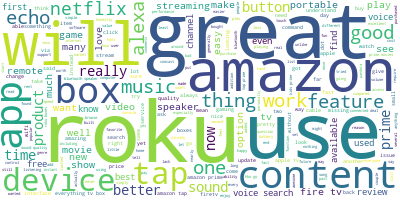

In [159]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['reviews_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [160]:
# Generating amazon tap word cloud
# Remove punctuation
df1['reviews_text_processed'] = \
df1['reviews.text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df1['reviews_text_processed'] = \
df1['reviews_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df1['reviews_text_processed'].head()

852    important update (3/8/17): as you read my original review please be aware that amazon announced in early february (2017) a new firmware update that allows amazon tap owners to enable a hands-free option by going into settings in the alexa app you can now choose the hands-free option and have you...
853    it was just a few weeks ago that i was bemoaning the fact that i did not scoop up an echo back when they were being released last year not only could it be had at nearly half off the current price but it came with a voice remote and we could have had a year longer using this amazing devicewell h...
854    the amazon tap is a portable bluetooth speaker that can be controlled with your voice you can instruct it to play music order products and services control home automation products and connected devices plus a whole lot moreit contains a button activated microphone for listening to your verbal c...
855    look at this product as a portable speaker first and an echo replacement

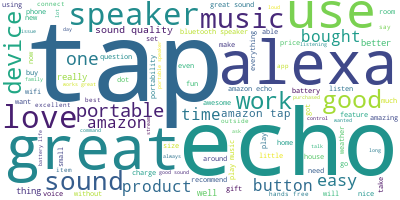

In [161]:
# Join the different processed titles together.
long_string = ','.join(list(df1['reviews_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [162]:
# Generating amazon fire tv word cloud
# Remove punctuation
df2['reviews_text_processed'] = \
df2['reviews.text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df2['reviews_text_processed'] = \
df2['reviews_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df2['reviews_text_processed'].head()

288    an amazoncom official commented on this review(what's this) the amazon team saysjuly 30 2014hi dallas thank you for sharing your feedback we wanted to let you know that we made it easier to find your favorite prime content with the click of your remote you can now browse many more prime-only cat...
289    i'm your typical middle-aged woman - i don't game and i'm not super tech-savvy by any meansso take this review for what it is the fire tv was easy to install and i'm loving all the features free movies music and simple interface - this thing even has a screen saver that comes on when you're list...
290    having received my fire tv today i've been trying it out for the past couple of hourssetup was a no brainer it required an update immediately so it did take about 15 minutes to have it in action but the process was very simplethe image quality (movies and games) is excellent i've tried several m...
291    i'm your typical middle-aged woman - i don't game and i'm not super tech

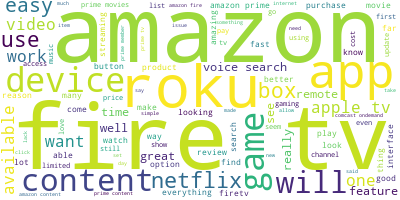

In [163]:
# Join the different processed titles together.
long_string = ','.join(list(df2['reviews_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## LDA Model

In [164]:
 # tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['bought', 'as', 'gift', 'for', 'my', 'daughter', 'actually', 'sounds', 'better', 'and', 'easier', 'to', 'set', 'up', 'than', 'expected', 'the', 'personal', 'assistant', 'feature', 'is', 'really', 'amazing', 'instant', 'response', 'to', 'requests', 'for', 'information', 'and', 'music']


In [165]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['to', 'screen', 'movies', 'for', 'music'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['great', 'piece', 'hardware', 'love', 'really', 'good', 'around']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qinrenkang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [166]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [167]:
from pprint import pprint

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5)

# Print the Keyword in the 50 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"prime" + 0.017*"amazon" + 0.012*"tv" + 0.010*"roku" + 0.007*"use" + '
  '0.007*"like" + 0.007*"content" + 0.007*"box" + 0.006*"one" + 0.006*"voice"'),
 (1,
  '0.014*"roku" + 0.009*"box" + 0.009*"amazon" + 0.009*"voice" + 0.009*"tv" + '
  '0.009*"tap" + 0.006*"use" + 0.005*"device" + 0.005*"one" + 0.005*"great"'),
 (2,
  '0.009*"amazon" + 0.008*"good" + 0.008*"great" + 0.008*"prime" + '
  '0.007*"roku" + 0.007*"better" + 0.007*"tap" + 0.007*"tv" + 0.006*"like" + '
  '0.006*"nsprefix"'),
 (3,
  '0.014*"tap" + 0.011*"great" + 0.008*"amazon" + 0.008*"roku" + 0.008*"use" + '
  '0.008*"prime" + 0.007*"sound" + 0.007*"tv" + 0.007*"echo" + 0.006*"box"'),
 (4,
  '0.012*"amazon" + 0.012*"roku" + 0.011*"tv" + 0.010*"great" + 0.010*"box" + '
  '0.010*"use" + 0.009*"prime" + 0.009*"alexa" + 0.008*"content" + '
  '0.008*"app"')]


In [168]:
#calculating model perplexity

perplexity = lda_model.log_perplexity(corpus)

In [169]:
#printing model perplexity

print(perplexity)

-7.470586806558179


In [170]:
plist = []
for num in range(2, 51):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num)
    perplexity = lda_model.log_perplexity(corpus)
    plist.append(perplexity)
print(plist)

[-7.077251006218169, -7.222131098909044, -7.322210724136393, -7.499534587563207, -7.624130983896604, -7.7465977390165515, -7.88013314229479, -8.057906881210583, -8.033504810001766, -8.254030510109443, -8.21285419294101, -8.639128749846245, -8.488956082401728, -8.789487424746616, -8.85688037669515, -8.970309238911753, -9.174164330388876, -9.07553229854353, -9.442982867551011, -9.33526294396035, -9.518420459558035, -9.486012155096066, -9.666929031011298, -9.956955382573756, -10.12743272873227, -10.000097232839176, -9.848059426743282, -10.144467965565683, -10.157239268159813, -10.510785752802121, -10.36532707038506, -10.743650601335998, -10.781318191239595, -10.742803202539166, -10.8746542615736, -11.346576231769717, -11.376433699188954, -11.048654073676671, -11.261710601535253, -11.19858909708805, -11.385886381320605, -11.771151414661814, -11.694124202554892, -11.673491031178516, -11.775239264798865, -11.93255035841968, -11.619489171964025, -11.941804975248766, -12.047215837853335]


In [171]:
print(min(plist))

-12.047215837853335


In [172]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, corpus=corpus,coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -3.2044327728545694


In [173]:
clist = []
for num in range(2, 51):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_words, 
                                         dictionary=id2word, 
                                         corpus=corpus,coherence='u_mass',

                                         )
    coherence_lda = coherence_model_lda.get_coherence()
    clist.append(coherence_lda)
print(clist)

[-2.378451946362683, -2.6736126405068, -2.2728937880829254, -2.51026901480179, -3.80545975338557, -3.3744374525200067, -3.356016872904927, -3.125269962625986, -3.5366833093510825, -3.6598196852700964, -3.3291938034460355, -3.706550880323901, -2.739339603339077, -2.9684453686726187, -3.4135449193282077, -3.682578712701257, -3.7934664020511417, -2.8474915654569717, -3.9478466068022606, -3.5717148299850385, -2.9007250902084136, -3.5007821111110675, -4.257577844331482, -3.586518158560628, -4.141919544305368, -3.302143804035389, -4.243613451655228, -3.724860758000302, -4.411240403238308, -3.383037139116003, -4.08089940601743, -4.368716546088553, -3.7073868637846354, -3.342174564657088, -4.329228171612786, -4.235372146983407, -3.7794026328064048, -4.136241843192513, -3.8625101204537295, -3.4415792657149566, -3.5991905765380103, -4.279065830212503, -4.257409738095782, -3.719977541457437, -4.304593449273768, -3.753219250067721, -4.025260047176104, -3.8124997229859585, -3.669152947014346]


In [174]:
print(min(clist))

-4.411240403238308


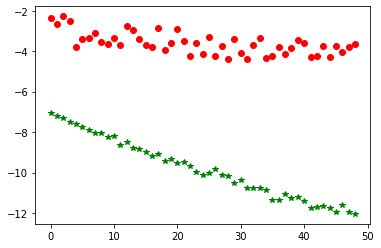

In [175]:
plt.plot(plist,'g*', clist, 'ro')
plt.show()

In [176]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: Depreca

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.056848 -0.014141       1        1  22.558662
4      0.173070 -0.053862       2        1  11.329567
1      0.007547  0.038334       3        1  10.189825
5     -0.091701 -0.170149       4        1   8.032224
36     0.064890 -0.028568       5        1   7.187845
24     0.050313 -0.072762       6        1   3.728933
22     0.008063  0.003903       7        1   3.626513
19    -0.070433 -0.021073       8        1   2.659514
13    -0.049305  0.029965       9        1   2.638091
35    -0.031388 -0.025710      10        1   2.490568
9     -0.015181  0.005032      11        1   2.259296
25     0.031344 -0.043570      12        1   2.140595
31    -0.025034  0.004484      13        1   2.057047
10    -0.058268 -0.094003      14        1   1.600829
7     -0.018606 -0.012923      15        1   1.581366
37     0.006644  0.051051      16        1   1.451463
39    -0.035142  0.020399      17        1   1.264621
33    -0.001312 -0.049193      18        1   1.171080
38     0.024643  0.016584      19        1   1.036372
3     -0.028291  0.008780      20        1   1.027154
29    -0.030356  0.006300      21        1   0.990403
47    -0.033502 -0.048783      22        1   0.978504
12    -0.023379  0.045874      23        1   0.972412
46    -0.007100  0.020070      24        1   0.702342
45    -0.040807  0.009041      25        1   0.685204
15    -0.031392 -0.049589      26        1   0.635671
11    -0.021467  0.019833      27        1   0.624860
43    -0.042504 -0.066091      28        1   0.544451
40    -0.013899  0.013041      29        1   0.516831
20    -0.034481  0.033800      30        1   0.455531
21    -0.025730  0.035838      31        1   0.415154
41     0.026783 -0.004620      32        1   0.396696
26     0.076098  0.001526      33        1   0.375187
27    -0.025274  0.041658      34        1   0.373941
23    -0.010492  0.044707      35        1   0.243818
32    -0.028400  0.007520      36        1   0.177392
8     -0.009869  0.040908      37        1   0.169105
0     -0.015437  0.019369      38        1   0.150527
28     0.002404  0.030269      39        1   0.113633
14    -0.008804  0.042323      40        1   0.095421
34     0.065211 -0.007400      41        1   0.035135
30    -0.004300  0.031701      42        1   0.035135
17     0.109514 -0.012261      43        1   0.035135
42     0.022450  0.002143      44        1   0.035135
16    -0.004429  0.032148      45        1   0.035135
44    -0.034736  0.017569      46        1   0.035135
6     -0.010017  0.050760      47        1   0.035135
2      0.041472  0.014329      48        1   0.035135
48    -0.016206  0.040486      49        1   0.035135
49     0.129946 -0.005047      50        1   0.035135, topic_info=        Term       Freq      Total Category  logprob  loglift
199    prime  92.000000  92.000000  Default  30.0000  30.0000
16      roku  63.000000  63.000000  Default  29.0000  29.0000
201       tv  65.000000  65.000000  Default  28.0000  28.0000
53    amazon  79.000000  79.000000  Default  27.0000  27.0000
361      box  44.000000  44.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
222     free   0.010439  22.062425  Topic50  -5.1854   0.2977
64       one   0.010138  26.180899  Topic50  -5.2147   0.0972
179     like   0.009834  29.678732  Topic50  -5.2451  -0.0586
252    watch   0.009123  17.214291  Topic50  -5.3202   0.4110
339  quality   0.008878  22.205799  Topic50  -5.3474   0.1292

[2825 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
327       1  0.237123  ability
327       5  0.237123  ability
327       9  0.237123  ability
327      17  0.237123  ability
327      23  0.237123  ability
...     ...       ...      ...
437      10  0.163140     xbox
439       1  0.215380      yet
439       2  0.323071      yet
439       4  0.107690     

In [177]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word,corpus=corpus, coherence='u_mass')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [178]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15, 20,30,40,50]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

In [179]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

alpha  num_topics  coherence_value
0    0.01           2        -2.375638
1    0.01           6        -4.283037
2    0.01          10        -3.004930
3    0.01          15        -4.014755
4    0.01          20        -3.759872
5    0.01          30        -3.440064
6    0.01          40        -3.949285
7    0.01          50        -3.634831
8    0.10           2        -2.489150
9    0.10           6        -3.473284
10   0.10          10        -3.634932
11   0.10          15        -3.481999
12   0.10          20        -3.673945
13   0.10          30        -3.705841
14   0.10          40        -3.983446
15   0.10          50        -3.785997
16   1.00           2        -2.892445
17   1.00           6        -2.922366
18   1.00          10        -2.429828
19   1.00          15        -2.646544
20   1.00          20        -2.650874
21   1.00          30        -2.701015
22   1.00          40        -2.800360
23   1.00          50        -2.699109

In [180]:
coherence_df.sort_values('coherence_value')

alpha  num_topics  coherence_value
1    0.01           6        -4.283037
3    0.01          15        -4.014755
14   0.10          40        -3.983446
6    0.01          40        -3.949285
15   0.10          50        -3.785997
4    0.01          20        -3.759872
13   0.10          30        -3.705841
12   0.10          20        -3.673945
10   0.10          10        -3.634932
7    0.01          50        -3.634831
11   0.10          15        -3.481999
9    0.10           6        -3.473284
5    0.01          30        -3.440064
2    0.01          10        -3.004930
17   1.00           6        -2.922366
16   1.00           2        -2.892445
22   1.00          40        -2.800360
21   1.00          30        -2.701015
23   1.00          50        -2.699109
20   1.00          20        -2.650874
19   1.00          15        -2.646544
8    0.10           2        -2.489150
18   1.00          10        -2.429828
0    0.01           2        -2.375638

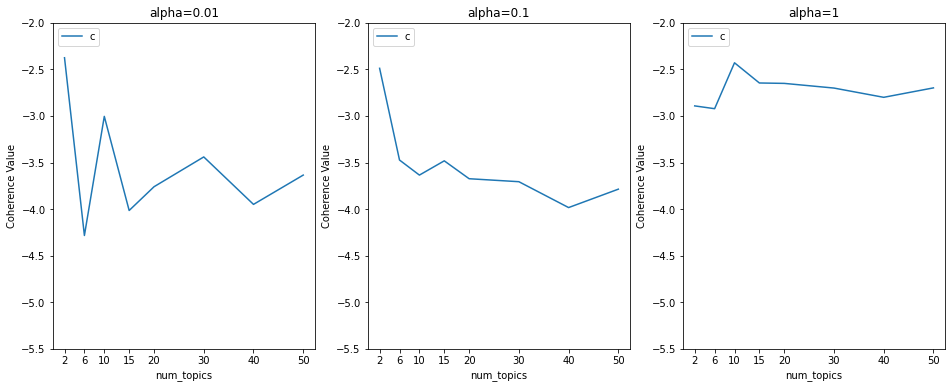

In [181]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([-5.5, -2])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df, alpha_range, num_topics_range)

## Jaccard Score

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [183]:
# Considering 1-50 topics, as the last is cut off
num_topics = list(range(51)[1:])
num_keywords = 10

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [184]:
shown_topics

[(0,
  [('roku', 0.01553941),
   ('box', 0.01511204),
   ('tv', 0.010756472),
   ('content', 0.0095025115),
   ('app', 0.007923485),
   ('like', 0.007220632),
   ('netflix', 0.0069659255),
   ('use', 0.006515578),
   ('fire', 0.006239406),
   ('amazon', 0.006159187)]),
 (1,
  [('alexa', 0.015658708),
   ('tap', 0.013815209),
   ('especially', 0.013446662),
   ('review', 0.013315129),
   ('one', 0.013098295),
   ('details', 0.013016873),
   ('like', 0.012772831),
   ('nite', 0.012565554),
   ('amazon', 0.01231526),
   ('button', 0.011644373)]),
 (2,
  [('box', 0.017867511),
   ('roku', 0.015261516),
   ('tv', 0.010789046),
   ('voice', 0.00928551),
   ('better', 0.008790199),
   ('content', 0.008419124),
   ('quality', 0.008178713),
   ('would', 0.0075),
   ('like', 0.0074944957),
   ('good', 0.007439532)]),
 (3,
  [('love', 0.025721667),
   ('tap', 0.021685177),
   ('great', 0.016399633),
   ('portable', 0.015912017),
   ('use', 0.014811224),
   ('see', 0.014473209),
   ('really', 0.01

In [185]:
a = pd.DataFrame(shown_topics, columns=["topic number", "topic"]).transpose()

In [186]:
pd.options.display.max_colwidth = 300

In [187]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):  # more options can be specified also
    display(a)

0   \
topic number                                                                                                                                                                                                                      0   
topic         [(roku, 0.01553941), (box, 0.01511204), (tv, 0.010756472), (content, 0.0095025115), (app, 0.007923485), (like, 0.007220632), (netflix, 0.0069659255), (use, 0.006515578), (fire, 0.006239406), (amazon, 0.006159187)]   

                                                                                                                                                                                                                                           1   \
topic number                                                                                                                                                                                                                                1   
topic         [(alexa, 0.015658708), (tap, 0.013815209), (especially, 0.013446662), (review, 0.013315129), (one, 0.013098295), (details, 0.013016873), (like, 0.012772831), (nite, 0.012565554), (amazon, 0.01231526), (button, 0.011644373)]   

                                                                                                                                                                                                                                2   \
topic number                                                                                                                                                                                                                     2   
topic         [(box, 0.017867511), (roku, 0.015261516), (tv, 0.010789046), (voice, 0.00928551), (better, 0.008790199), (content, 0.008419124), (quality, 0.008178713), (would, 0.0075), (like, 0.0074944957), (good, 0.007439532)]   

                                                                                                                                                                                                                                        3   \
topic number                                                                                                                                                                                                                             3   
topic         [(love, 0.025721667), (tap, 0.021685177), (great, 0.016399633), (portable, 0.015912017), (use, 0.014811224), (see, 0.014473209), (really, 0.014412823), (button, 0.013588622), (amazing, 0.013495223), (fact, 0.0134653635)]   

                                                                                                                                                                                                                                 4   \
topic number                                                                                                                                                                                                                      4   
topic         [(prime, 0.07343337), (tv, 0.025524242), (amazon, 0.01829961), (kids, 0.014658844), (top, 0.013833664), (genre, 0.013746443), (content, 0.013012967), (find, 0.01116963), (like, 0.011022458), (remote, 0.010022537)]   

                                                                                                                                                                                                                                   5   \
topic number                                                                                                                                                                                                                        5   
topic         [(like, 0.013711114), (update, 0.009018778), (tv, 0.008516129), (would, 0.008500317), (amazon, 0.008169424), (use, 0.007866318), (product, 0.0074060895), (new, 0.007403359), (roku, 0.006344381), (box, 0.0061075827)]   

       

In [188]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [189]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [190]:
#clist

In [191]:
coh_sta_diffs = [clist[i] - mean_stabilities[i] for i in range(num_topics[-2])] # limit topic numbers to the number of keywords
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [192]:
#coh_sta_diffs

In [193]:
ideal_topic_num

29

In [194]:
coh_sta_max

-4.574399025770262

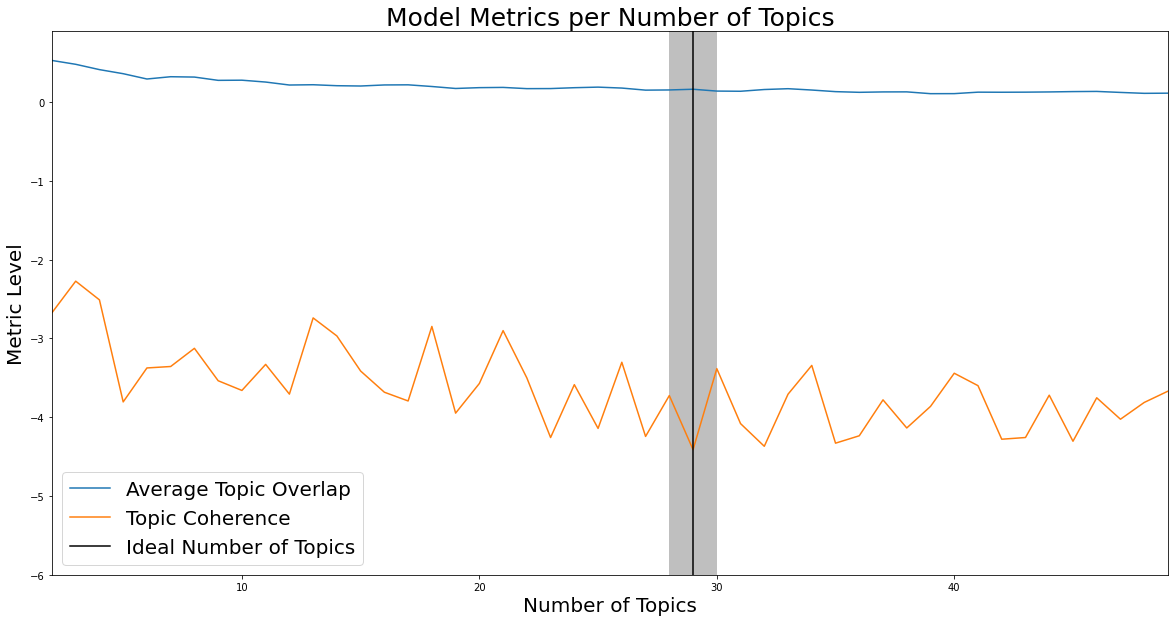

In [195]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=clist, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(clist)) + (0.10 * max(max(mean_stabilities), max(clist)))
ax.set_ylim([-6, y_max])
ax.set_xlim([2, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

## NMF Model

In [196]:
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/qinrenkang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/qinrenkang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [197]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''    
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)    
    
    return text

In [198]:
round1 = lambda x: clean_text_round1(x)

# Clean Speech Text
df["reviews.text"] = df["reviews.text"].apply(round1)

# Visually Inspect
df.head()

id       asins  \
1253  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
369   AVpfLiCSilAPnD_xWpk_  B00CX5P8FC   
1206  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
1308  AVpfpK8KLJeJML43BCuD  B01BH83OOM   
1111  AVpfpK8KLJeJML43BCuD  B01BH83OOM   

                                                       name  \
1253  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
369                                          Amazon Fire TV   
1206  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
1308  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   
1111  Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker   

                  reviews.date  \
1253  2016-09-23T00:00:00.000Z   
369       2014-04-29T05:00:00Z   
1206  2016-11-01T00:00:00.000Z   
1308  2016-07-29T00:00:00.000Z   
1111  2017-01-06T00:00:00.000Z   

                                                                                                                                                                                                                                                                                        reviews.text  \
1253                                                                                                                                                                                                                         this is a great piece of hardware   i love it  really good all around     
369                                                                                                                            when you add the mlb and pbs aps i will switch from roku      roku customer service is terrible and they dont seem to care if you re happy with their product or not    
1206                                                                                                                                      excellent sound and fun  very portable and easy to carry in backpack  all the features of echo and echo dot but you must  tap  the button before speaking    
1308                                                                                          bought as a gift for my daughter  actually sounds better and easier to set up than expected  the personal assistant feature is really amazing  instant response to requests for information and music    
1111  love this product  it is nice looking  easy to carry  and the sound is amazing  very easy to set up and connect to amazon echo  nothing to complain about th he speaker itself  however the carrying case is kind of stupid and useless also  one has to take it down just in order to charge    

                                reviews.title reviews.username  \
1253          lovely speaker with many extras          Dspeers   
369                            Amazon Fire TV    Thomas Smolen   
1206             Great Portable Speaker & Fun           Ranger   
1308  pleasant surprise, better than expected            Vette   
1111                                  Amazing          Niceguy   

                                                                                                                                                                                                                                                                      reviews_text_processed  
1253                                                                                                                                                                                                                       this is a great piece of hardwarei love it really good all around  
369                                                                                                                           when you add the mlb and pbs aps i will switch from rokuroku customer service is terrible and they dont seem to care if you're happy with their product or not  
1206                                                                                                                                 excellent sound and

In [199]:
# Noun extract and lemmatize function

def nouns(text):
    #Given a string of text, tokenize the text 
    #and pull out only the nouns.   
    
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'    
    
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)    
    
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()    
    
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

# Create dataframe of only nouns from speeches
data_nouns = pd.DataFrame(df['reviews.text'].apply(nouns))
data_nouns = data_nouns.rename(columns={'reviews.text': 'text'})

# Visually Inspect
data_nouns.head()

text
1253                                                            piece hardware i
369                                mlb pb aps roku roku customer service product
1206                             sound backpack feature echo dot button speaking
1308  gift daughter assistant feature instant response request information music
1111                                    product sound nothing th case kind order

In [200]:
# Add additional stop words since we are recreating the document-term matrix
stop_noun = [ 'screen', 'movies', 'music']
stop_words_noun_agg = text.ENGLISH_STOP_WORDS.union(stop_noun)

# Create a document-term matrix with only nouns

# Store TF-IDF Vectorizer
tv_noun = TfidfVectorizer(stop_words=stop_words_noun_agg, ngram_range = (1,1), max_df = 1, min_df = .01)


# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_tv_noun = tv_noun.fit_transform(data_nouns.text)

# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names_out())

# Set President's Names as Index
data_dtm_noun.index = df.index

# Visually inspect Document Term Matrix
data_dtm_noun.head()

accent  adjusting  adjusts  advantage  alexia  alexis  android  \
1253     0.0        0.0      0.0        0.0     0.0     0.0      0.0   
369      0.0        0.0      0.0        0.0     0.0     0.0      0.0   
1206     0.0        0.0      0.0        0.0     0.0     0.0      0.0   
1308     0.0        0.0      0.0        0.0     0.0     0.0      0.0   
1111     0.0        0.0      0.0        0.0     0.0     0.0      0.0   

      appliance       aps  arm  ...  wemo   wi  window  wise  wold  world  \
1253        0.0  0.000000  0.0  ...   0.0  0.0     0.0   0.0   0.0    0.0   
369         0.0  0.707107  0.0  ...   0.0  0.0     0.0   0.0   0.0    0.0   
1206        0.0  0.000000  0.0  ...   0.0  0.0     0.0   0.0   0.0    0.0   
1308        0.0  0.000000  0.0  ...   0.0  0.0     0.0   0.0   0.0    0.0   
1111        0.0  0.000000  0.0  ...   0.0  0.0     0.0   0.0   0.0    0.0   

      worry  worth  xbox  youtube  
1253    0.0    0.0   0.0      0.0  
369     0.0    0.0   0.0      0.0  
1206    0.0    0.0   0.0      0.0  
1308    0.0    0.0   0.0      0.0  
1111    0.0    0.0   0.0      0.0  

[5 rows x 354 columns]

In [201]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
#'''Given an NMF model, feature_names, and number of top words, print topic number 
#and its top feature names, up to specified number of top words.'''    
    
    # iterate through topics in topic-term matrix
    # model.components_
    for ix, topic in enumerate(model.components_):        
        
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [202]:
nmf_model = NMF(50)

# Learn an NMF model 
# Extract the document-topic matrix 
doc_topic = nmf_model.fit_transform(data_dtm_noun)

# Extract top words from the topic-term matrix  
display_topics(nmf_model, tv_noun.get_feature_names(), 10)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(



Topic  0
compact, bed, ijnfo, plan, planning, calendar, staff, youtube, forecast, form

Topic  1
alexia, clarity, staff, tab, course, habit, convenience, alexis, language, cnet

Topic  2
form, blown, someways, war, bruce, online, table, bolton, fit, figure

Topic  3
invention, audiophile, novelty, iphone, course, tab, habit, googletv, google, fit

Topic  4
engine, status, adjusts, quick, youtube, fit, folk, forecast, form, format

Topic  5
wold, grab, format, youtube, functionality, firmware, fit, folk, forecast, form

Topic  6
serf, pro, row, page, buffer, okay, firmware, nicer, hbogo, cancel

Topic  7
complement, console, hbo, end, comment, party, episode, processor, gaming, vevo

Topic  8
fargo, imho, source, feel, subscriber, light, love, novelty, audiophile, pro

Topic  9
aps, pb, adjusts, status, quick, tab, course, habit, usage, espn

Topic  10
refund, youtube, funny, fit, folk, forecast, form, format, forward, frill

Topic  11
funny, bug, hulu, watch, homepage, program, xbox, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [203]:
show_topics = (nmf_model, 10, None)
print(show_topics)

(NMF(n_components=50), 10, None)


In [204]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = data_nouns.text


# for each number of topics
coherence_scores = []

for num in range(1,51):
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=id2word
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        corpus=corpus,
        dictionary=id2word,
        coherence='u_mass'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))
    
print(coherence_scores)

[-1.17627, -1.15471, -1.10598, -1.19281, -1.37021, -1.59931, -1.14257, -1.38893, -2.00115, -2.42665, -1.61703, -1.56624, -1.53559, -1.57977, -2.22879, -1.88268, -1.86446, -2.35876, -2.35878, -2.26798, -2.31388, -2.29381, -2.39091, -2.72902, -2.52682, -2.18099, -2.28597, -2.39404, -2.20514, -2.5675, -2.97083, -2.63973, -3.69186, -2.78279, -2.8571, -3.86, -2.45724, -3.02513, -2.53184, -3.47817, -3.032, -3.42442, -2.93982, -3.17979, -3.07605, -2.43028, -2.92797, -3.94999, -2.62029, -3.16411]


In [205]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [206]:
nmf.show_topics(num_topics=15, num_words=10, log=True, formatted=True, normalize=None)

[(33,
  '0.005*"wifi" + 0.004*"connected" + 0.003*"tap" + 0.003*"purchase" + 0.003*"reads" + 0.003*"great" + 0.003*"stock" + 0.003*"small" + 0.003*"plays" + 0.003*"mentioning"'),
 (37,
  '0.006*"amazon" + 0.006*"product" + 0.006*"command" + 0.005*"money" + 0.005*"completely" + 0.005*"free" + 0.005*"programming" + 0.005*"brands" + 0.005*"similar" + 0.005*"ability"'),
 (24,
  '0.011*"echo" + 0.007*"button" + 0.007*"features" + 0.006*"like" + 0.005*"go" + 0.005*"get" + 0.005*"connection" + 0.005*"needed" + 0.005*"carry" + 0.005*"push"'),
 (17,
  '0.008*"app" + 0.007*"great" + 0.007*"works" + 0.006*"device" + 0.005*"daughter" + 0.005*"wish" + 0.005*"sound" + 0.005*"new" + 0.005*"get" + 0.004*"unusable"'),
 (13,
  '0.009*"time" + 0.009*"full" + 0.006*"blown" + 0.005*"going" + 0.005*"echo" + 0.005*"would" + 0.005*"tap" + 0.005*"ask" + 0.005*"echoes" + 0.004*"question"'),
 (9,
  '0.028*"ifrm" + 0.027*"nsprefix" + 0.027*"document" + 0.020*"alexa" + 0.018*"getelementbyid" + 0.018*"style" + 0.01

In [207]:
# Considering 1-51 topics, as the last is cut off
num_topics = list(range(51)[1:])
num_keywords = 50

NMF_models = {}
NMF_topics = {}
for i in num_topics:
    NMF_models[i] = Nmf(
        corpus=corpus,
        num_topics=i,
        id2word=id2word,
        random_state=42
    )

    shown_topics = NMF_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    NMF_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [208]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [209]:
NMF_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(NMF_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(NMF_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    NMF_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(NMF_stability[i]).mean() for i in num_topics[:-1]]

In [210]:
coherences = [CoherenceModel(model=NMF_models[i], texts=corpus, dictionary=id2word, corpus=corpus,coherence='u_mass').get_coherence()\
              for i in num_topics[:-1]]

In [211]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_topics[-2])] # limit topic numbers to the number of keywords
coh_sta_max = min(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [212]:
ideal_topic_num

29

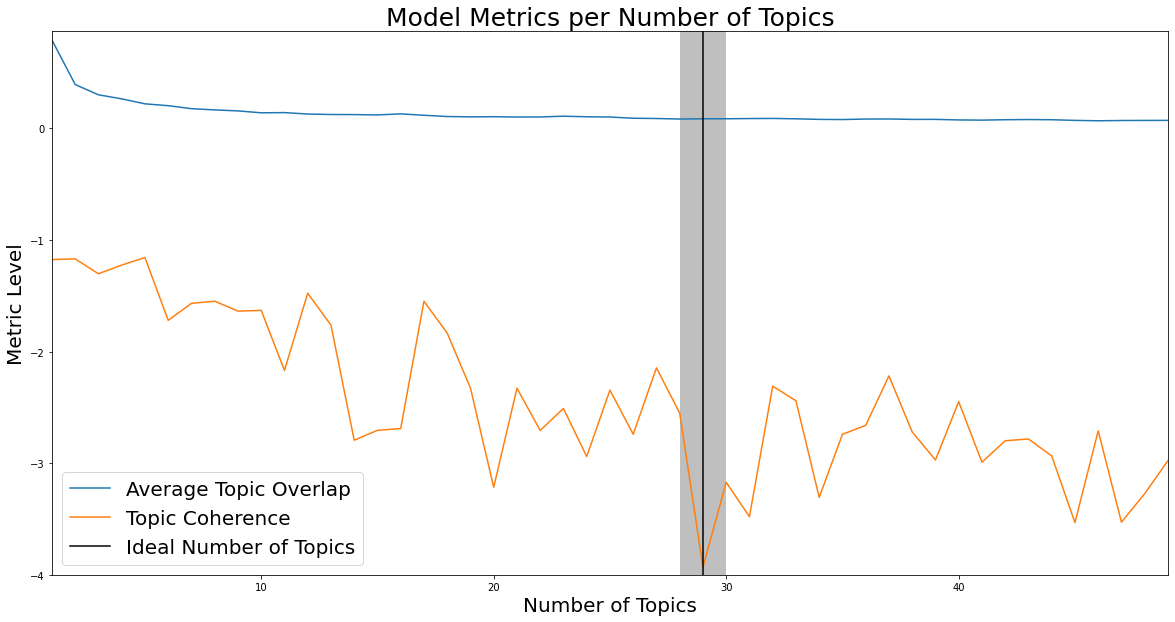

In [213]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([-4, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

In [214]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


## Corex Model

In [215]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

import corextopic.corextopic as ct
import corextopic.vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [216]:
# Transform data into a sparse matrix
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(data_nouns.text)
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(100, 636)

In [217]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [218]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(100, 636)

## Unsupervised Corex model 

In [219]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=40, words=words, max_iter=200, verbose=False, seed=2)
topic_model.fit(doc_word, words=words);

In [220]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: niche, htpc, site, summary, tail, term, demand, coming, head, channel
1: resolution, plex, selection, type, setting, thanks, company, stream, streamer, menu
2: satellite, wife, access, wifi, wait, nobody, operating, party, patio, person
3: apps, couple, isn, image, setup, category, minute, quality, device, membership
4: style, provider, people, hdmi, try, function, px, parent, note, heighth
5: someone, fun, line, annoying, class, performance, future, etc, medium, rating
6: home, service, amount, streaming, pandora, don, year, audio, control, competitor
7: saver, comcast, release, mean, ondemand, season, savvy, rent, pc, tech
8: tv, movie, amazon, review, game, show, kid, deal, prime, speaker
9: fire, everything, software, thing, member, today
10: com, feedback, genre, official, team, thank, arm, rep, stock
11: box, roku, video, user, lag, customer, doesn, aps, awhile, describe
12: netflix, hour, anything, list, sense, support, answer, version, pain
13: guess, bit, bed, bug, calendar

In [221]:
topic_model

In [222]:
topic_model.tc

29.817841289021402

In [223]:
tc_list = []
for i in range(2,50):
    topic_model = ct.Corex(n_hidden=i, words=words, max_iter=200, verbose=False, seed=1)
    topic_model.fit(doc_word, words=words);
    #topic_model.get_top_docs(topic=i, n_docs=10, sort_by='log_prob')
    tc_list.append(topic_model.tc)

In [224]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

30.650488774402238
30.650488774402238


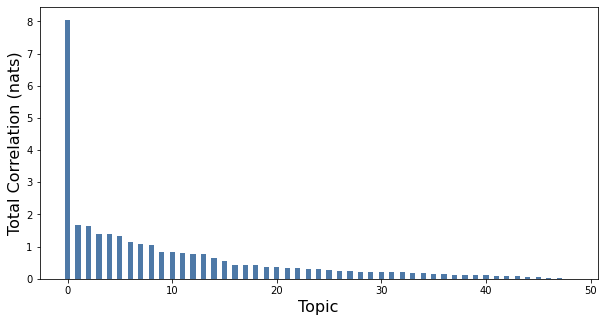

In [225]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

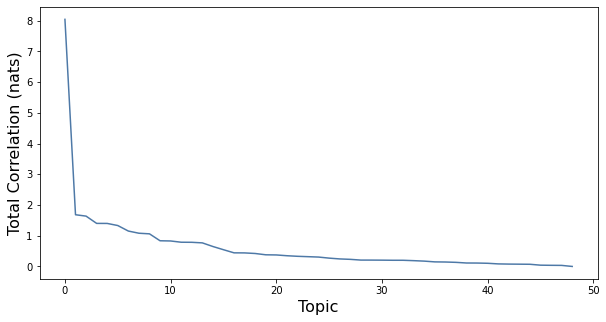

In [226]:
plt.figure(figsize=(10,5))
plt.plot(range(topic_model.tcs.shape[0]),topic_model.tcs, color='#4e79a7')
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.show()

## Semi-Supervised Corex Topic Modeling

In [227]:
# Anchor one word to each topic
anchor_words = [['activity'],['reader'],['display'], ['gaming'],['company'], ['roku'], ['niche'], ['streaming'],['hbo'],['texas'],['software'],
                ['app'], ['internet'], ['comcast'], ['service'], ['hardware'], ['beef'], ['tv'], ['sale'], ['store'], ['anybody'],['problem'],
                ['accessory'],['wifi'],['family'],['siri'],['review'],['try'],['ability'],['computer'],['amazon'],['speaker'],['christmas'],
                ['firetv'],['room'],['south'],['gathering'],['awesome'],['weather'],['choice'],['tune'],['stand'],['tech'],['battery'],
                ['netflix'],['son'],['access'],['functionality'],['pro'],['news']]

In [229]:
# Anchor the word 'activity' to the first topic, 'reader' to the second topic, and so on...
anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [231]:
# loop through and show each of the most relevant words
for n in range(len(anchor_words)):
    topic_words,_,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ', '.join(topic_words))

0: gaming, future, performance, plex, medium, type, rating, selection, setting, class
1: company, everyone, option, player, resolution, site, demand, streamer, coming, stream
2: roku, user, change, customer, drive, aps, pb
3: niche, broadcast, wdtv, htpc, term, head, note, brand, play, power
4: streaming, range, home, control, limit
5: hbo, apps, couple, everything, way, minute, today, quality, device
6: software, member, screen, mean, feature
7: app, phone, engine
8: internet, simple, plain, substitute, go
9: comcast, cable, interface, time, thing, voice, hdmi, people, provider, yesterday
10: service, recognition
11: hardware, fun, annoying, line, someways, run, piece, online, table, form
12: tv, fire, remote, content, movie, kid
13: sale, plus
14: store, arm, bed, calendar, detail, ijnfo, plan, planning, rep, stock
15: problem, release, saver, purchase, developer, itunes, mess, picture, policy, starter
16: wifi, music, doesn, awhile
17: family, addition, vudu, tax, spear, showtime, s

In [232]:
# store a file to my local drive
vt.vis_rep(topic_model, column_label=words, prefix='Qinren_Corex')

Print topics in text file


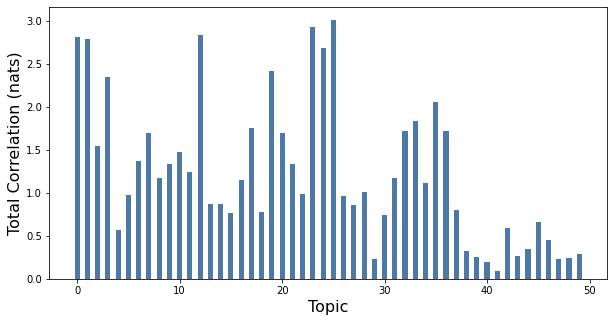

In [233]:
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## Biterm

In [234]:
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary

stpwrd = nltk.corpus.stopwords.words('english')
new_stopwords=['activity','reader','display']
stpwrd.extend(new_stopwords)
vec = CountVectorizer(stop_words=stpwrd)
X = vec.fit_transform(data_nouns.text).toarray()

vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)
from biterm.cbtm import oBTM

btm = oBTM(num_topics=50, V=vocab)
topics = btm.fit_transform(biterms, iterations=50)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|███████████████████████████████████████████| 50/50 [01:59<00:00,  2.40s/it]


In [235]:
topic_summuary(btm.phi_wz.T, X, vocab, 10)

Topic 0 | Coherence=-22.03 | Top words= roku device interface broadcast item everyone quality cost site content
Topic 1 | Coherence=-36.83 | Top words= amazon netflix review remote update thing game deal box hour
Topic 2 | Coherence=-40.35 | Top words= music volume weather ability report alexa speaker song apple home
Topic 3 | Coherence=20.62 | Top words= consumer technology budget chromecast example failure quicker review product system
Topic 4 | Coherence=-19.83 | Top words= content app peck rating provider search omission water googletv keyboard
Topic 5 | Coherence=-17.21 | Top words= cable fact tv page period apps review company hardware second
Topic 6 | Coherence=-4.93 | Top words= company pro interface review row feeling hardware service warner second
Topic 7 | Coherence=-44.80 | Top words= thing product app amazon netflix button lot option issue tv
Topic 8 | Coherence=-50.54 | Top words= tap echo dot amazon button command friend voice question sound
Topic 9 | Coherence=19.63 | T

{'coherence': [-22.029502247594905,
  -36.8301588883493,
  -40.35035070346314,
  20.622565159871677,
  -19.832948658449176,
  -17.208968367532254,
  -4.926310645526381,
  -44.79663610041023,
  -50.54416160035207,
  19.630136093612872,
  -8.9028721720921,
  -68.68408468049725,
  -19.02594884141785,
  4.776997333593485,
  -9.894221975121965,
  -43.14700832012418,
  0.3510920802095534,
  -8.9028721720921,
  -56.849000037980886,
  -33.30172116815866,
  -18.16919784244652,
  -6.580796305275117,
  -54.45598649973971,
  -29.549364950232594,
  -3.4276687453738566,
  -14.574512755371803,
  -30.81432184117151,
  -60.197569227197505,
  6.8502253084991285,
  -18.445525783949495,
  -0.9178358251391706,
  2.2879055462358933,
  -30.184168088484128,
  -5.221127727856906,
  -2.158828503960748,
  12.129046295963178,
  23.501337104520754,
  22.451286382467075,
  14.778105829693262,
  19.18384899098445,
  -0.02549021743733282,
  -26.573639842954915,
  -30.083469750954066,
  13.663516586502015,
  -64.10811

In [236]:
for i in range(0, 1): 
        biterms_chunk = biterms[i:i + 100]
        btm.fit(biterms_chunk, iterations=10)

print("\n\n Topic coherence ..")
res, C_z_sum = topic_summuary(btm.phi_wz.T, X, vocab, 10)
print(res)

100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]



 Topic coherence ..
Topic 0 | Coherence=-31.03 | Top words= device roku quality interface everyone content broadcast cost product item
Topic 1 | Coherence=-28.94 | Top words= netflix review deal play amazon anything thing movie home box
Topic 2 | Coherence=-38.78 | Top words= music weather volume report apple alexa speaker ability home app
Topic 3 | Coherence=23.57 | Top words= consumer chromecast budget example technology quicker brand system priority coming
Topic 4 | Coherence=-13.76 | Top words= content app purchasing provider googletv peck search rating classy work
Topic 5 | Coherence=-9.60 | Top words= cable apps fact page tv period company interface feeling review
Topic 6 | Coherence=-9.69 | Top words= interface company service row pro fire playback warner review feeling
Topic 7 | Coherence=-48.79 | Top words= product app button thing tv netflix amazon fire issue sense
Topic 8 | Coherence=-41.88 | Top words= echo tap dot command friend button sound question voice amazon
Topic 9

In [237]:
import bitermplus as btm
import numpy as np
import pandas as pd
import tmplot as tmp
import plotly.express as px

In [238]:
# Importing data

texts = data_nouns.text.str.strip().tolist()

# Vectorizing documents, obtaining full vocabulary and biterms
# Internally, btm.get_words_freqs uses CountVectorizer from sklearn
# You can pass any of its arguments to btm.get_words_freqs
# For example, you can remove stop words:
stop_words = ['activity','reader','display']
X, vocabulary, vocab_dict = btm.get_words_freqs(texts, stop_words=stop_words)
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [239]:
# INITIALIZING AND RUNNING MODEL
plist=[]
clist=[]
for n in range(1,51):
    model = btm.BTM(X, vocabulary, seed=12321, T=n, M=20, alpha=50/8, beta=0.01)
    model.fit(biterms, iterations=10)
    p_zd = model.transform(docs_vec)
    perplexity = model.perplexity_
    plist.append(perplexity)
    coherence = model.coherence_
    clist.append(coherence)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 31808.77it/s]


In [240]:
# Metrics

#print(plist)

coherence_means = []
perplexity = []
for i in clist:
    mean = i.mean()
    coherence_means.append(mean)
for j in plist:
    perplexity.append(j)

print(coherence_means)
print(perplexity)

[-174.65215362918488, -195.0710947800623, -204.61881086850312, -195.73420027155635, -193.85611199206977, -170.55431870961587, -172.3325387777351, -181.27354776672115, -177.3049585046967, -171.63543819563594, -171.27970736594492, -161.02798803997115, -183.72806143519074, -177.52690126914408, -167.38995043995354, -175.415708858276, -159.03371182488738, -156.482806485805, -164.4908387828841, -161.62796938579945, -165.6093045817477, -146.44007593133807, -152.2915635328903, -160.68714633960928, -149.9631623916856, -144.72773884627537, -146.43698071631715, -152.47889880717207, -139.86655137583435, -147.95922238197332, -149.45828890395487, -146.8365834407008, -141.31796103972795, -150.33547199726476, -147.03651779288143, -146.04774221539512, -152.95741464131103, -145.30700902907833, -143.63090391187322, -137.39532019081253, -146.46017480038034, -141.8233733554201, -131.9386603856352, -141.09857662259577, -141.7965964565587, -138.0738475792867, -137.98885483783607, -135.0056249148852, -135.875

In [241]:
cdf = pd.DataFrame({'Average Coherence':coherence_means, 'Perplexity':perplexity})
cdf.insert(0, 'Topic Number', range(0, 0 + len(cdf)))
cdf

Topic Number  Average Coherence  Perplexity
0              0        -174.652154  301.194962
1              1        -195.071095  230.054331
2              2        -204.618811  202.022680
3              3        -195.734200  197.610170
4              4        -193.856112  181.516823
5              5        -170.554319  177.895084
6              6        -172.332539  171.082562
7              7        -181.273548  161.145123
8              8        -177.304959  161.476289
9              9        -171.635438  158.711513
10            10        -171.279707  154.042726
11            11        -161.027988  141.578164
12            12        -183.728061  141.789502
13            13        -177.526901  143.969787
14            14        -167.389950  135.164226
15            15        -175.415709  132.710071
16            16        -159.033712  131.036780
17            17        -156.482806  136.612065
18            18        -164.490839  127.350773
19            19        -161.627969  127.047441
20            20        -165.609305  127.669442
21            21        -146.440076  120.148259
22            22        -152.291564  126.290052
23            23        -160.687146  128.248798
24            24        -149.963162  116.691662
25            25        -144.727739  119.516826
26            26        -146.436981  120.070092
27            27        -152.478899  119.490690
28            28        -139.866551  117.090683
29            29        -147.959222  110.683516
30            30        -149.458289  108.628900
31            31        -146.836583  112.462945
32            32        -141.317961  109.698898
33            33        -150.335472  108.726403
34            34        -147.036518  111.249638
35            35        -146.047742  104.604594
36            36        -152.957415  110.592922
37            37        -145.307009  110.236194
38            38        -143.630904  108.354973
39            39        -137.395320   99.235140
40            40        -146.460175  100.769594
41            41        -141.823373  104.353906
42            42        -131.938660  102.707727
43            43        -141.098577  105.089224
44            44        -141.796596  104.695358
45            45        -138.073848  102.661911
46            46        -137.988855  101.928039
47            47        -135.005625   99.401860
48            48        -135.875314   99.521086
49            49        -141.593038  102.177162

In [242]:
fig=px.line(cdf, x='Topic Number', y=cdf.columns[1:3], template='plotly_white', color='variable')

fig.update_xaxes(nticks=20)
fig.update_layout(bargap=0.05)
fig.show()

In [243]:
# LABELS
model.labels_

array([38, 14, 44, 44, 19, 29,  4, 24,  3, 19, 44, 24,  3, 42, 15, 36, 16,
       27,  4,  4, 27, 37, 16, 37,  7,  7,  4,  3, 16, 16,  3, 37,  7,  8,
       17,  4,  4, 25, 39, 31, 16, 37, 35, 28,  1, 35,  4,  4, 23, 28, 16,
       29,  3,  4, 12,  4,  4, 13,  3, 16, 48,  8, 24,  5, 28, 38, 31, 22,
       26, 31, 16,  4, 24, 18, 44, 22, 39, 13,  4, 47, 16,  1,  5, 12, 46,
       24, 15, 39, 31, 32,  5,  1, 18, 45, 16,  2, 40, 25, 14,  3])

In [244]:
tmp.report(model=model, docs=texts, width=200, height=700)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tmplot/_helpers.py:38: UserWarning:

Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tmplot/_helpers.py:38: UserWarning:

Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.



In [245]:
doc_topics = btm.get_docs_top_topic(texts, model.matrix_docs_topics_)
doc_topics['topic'] = doc_topics['label']+1
doc_topics.topic.value_counts()

5     13
17    10
4      7
25     5
32     4
45     4
38     4
29     3
8      3
2      3
40     3
6      3
13     2
15     2
23     2
19     2
36     2
14     2
39     2
26     2
16     2
20     2
30     2
28     2
9      2
24     1
37     1
49     1
43     1
18     1
27     1
48     1
47     1
33     1
46     1
3      1
41     1
Name: topic, dtype: int64

In [246]:
doct = doc_topics['topic'].value_counts()
doct = pd.DataFrame(doct).reset_index().rename(columns={'index':'Topic','topic':'Number of Documents'})

In [247]:
fig=px.bar(doct, x='Topic', y='Number of Documents', template='plotly_white', color='Number of Documents')
fig.update_xaxes(nticks=40)
fig.update_layout(bargap=0.05)
fig.show()